# Itereative alpha-deblending

This project is based on the the paper [1]. In this paper, the authors propose a novel "deterministic, diffusion like model based on the sampling interpretation of blending and deblending" called interative $\alpha$-deblending

## I. Definitions
Interative $\alpha$-deblending allows for a deterministic mapping between two densities $p_0$ and $p_1$ using samples following these densities $x_0 \sim p_0$ and $x_1 \sim p_1$ and a blended sample $x_{\alpha} \sim p_{\alpha}$ such that $x_{\alpha} = (1-\alpha)x_0+\alpha x_1$ with $\alpha \in [0,1]$ .

In this case, $\alpha$-deblending consists in sampling posteriors $\left(x_0,x_1\right)_{(x_\alpha, \alpha)} \sim \left(p_0 \times p_1\right)_{(x_\alpha, \alpha)}$ knowing $x_\alpha$ and $\alpha$.

Iterative $\alpha$-deblending then relies on setting a number of iterations $T$ and a set of $\alpha _t = \frac{t}{T}$ with $t \in [0,T]$ evenly distributed to create a sequence of $(x_{\alpha_t} \sim p_{\alpha_t}, t \in [0,T])$ starting with a random sample $x_{\alpha_0}=x_0 \sim p_0$ and ending with a random sample $x_{\alpha_T}=x_T \sim p_T$.
Each sample $x_{\alpha_t}$ is then deblended to find posterior samples. These posteriors are then blended again with $\alpha_{t+1}$ to find a new sample $x_{\alpha_{t+1}} \sim p_{\alpha_{t+1}}$. The authors show that IADB provide a deterministic mapping between the two distributions $p_0$ and $p_1$ 

* Create samples for $x_1$

We will use the the swiss roll data set for the samples used for $x_1$

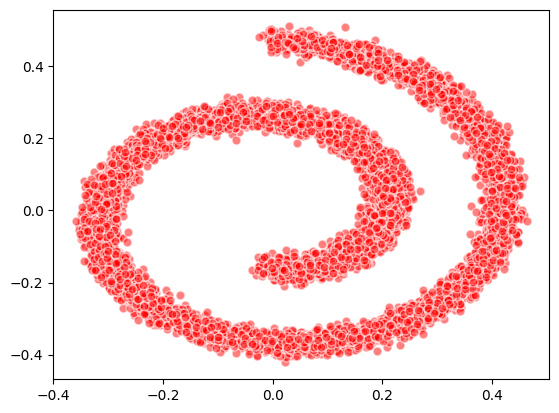

In [1]:
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt

def sample_batch(size, noise=1.1):
    x, _= make_swiss_roll(size, noise=0.5)
    #x, _= make_swiss_roll(size)
    return x[:, [0, 2]] / 10.0

x1 = sample_batch(10000).T/3
plt.scatter(*x1, alpha=0.5, color='red', edgecolor='white', s=40);

* Samples for $x_0$

Each samples $x_0$ will be sampled from noise

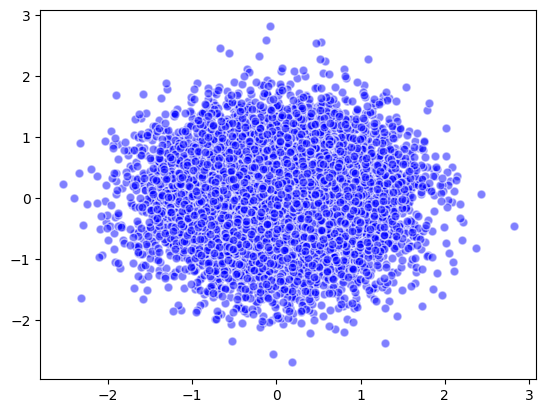

In [2]:
import torch
x1 = torch.from_numpy(x1)
x0 = torch.randn_like(x1)*0.7

plt.scatter(*x0, alpha=0.5, color='blue', edgecolor='white', s=40);

## II. Learning interative alpha-deblending

In the paper, the authors suggest to train a "deblender" neural network $D_\theta$ to predict the difference of the average posterior samples: $\bar x_1-\bar x_0$.

We will rely on a simple MLP network for this task

* Defining the network's architecture

In [47]:
import torch
from torch import nn
import torch.optim as optim
import numpy as np

* Sinusoidal positionnal encoding 

Sinusoidal positionnal encoding (SPE) is a technique used in tansformers to inject additional information about the position $t$ of a word in a sentence into the network. SPE is is encoded into a $d$ dimensional vector in this manner:

$$
\begin{bmatrix}
\text{sin}(\omega_1 t) \\
\text{sin}(\omega_1 t) \\
\vdots \\
\text{sin}(\omega_{d/2}) \\
\text{cos}(\omega_{d/2})
\end{bmatrix}
$$

with $\omega_{k}=\frac{1}{1000^{2k/d}}$

In [48]:
class SPE(nn.Module):
    def __init__(self, spe_dim : int):
        super().__init__()
        self.omega = 1/1000
        self.spe_dim = spe_dim
        

    def forward(self, alpha):
        denominators = torch.pow(self.omega, 2*torch.arange(0, self.spe_dim//2)/self.spe_dim)
        spe = torch.zeros(alpha.size(0), alpha.size(1),self.spe_dim)
        spe[:, 0::2] = torch.sin(alpha * denominators)
        spe[:, 1::2] = torch.cos(alpha * denominators)
        return(spe)

In [49]:
spe = SPE(10)
print(spe(torch.tensor([[0.5]])))

RuntimeError: The expanded size of the tensor (10) must match the existing size (5) at non-singleton dimension 2.  Target sizes: [1, 1, 10].  Tensor sizes: [5]

In [33]:
spe = SPE(64)
times = torch.linspace(0,1,40)
spe_emb = spe(times)
plt.imshow(spe_emb, aspect='auto')

tensor([0.0000, 0.0256, 0.0513, 0.0769, 0.1026, 0.1282, 0.1538, 0.1795, 0.2051,
        0.2308, 0.2564, 0.2821, 0.3077, 0.3333, 0.3590, 0.3846, 0.4103, 0.4359,
        0.4615, 0.4872, 0.5128, 0.5385, 0.5641, 0.5897, 0.6154, 0.6410, 0.6667,
        0.6923, 0.7179, 0.7436, 0.7692, 0.7949, 0.8205, 0.8462, 0.8718, 0.8974,
        0.9231, 0.9487, 0.9744, 1.0000])
40


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

This is what it should look like : 
![image.png](attachment:image.png)

In [34]:
class MLP(nn.Module):
    def __init__(self, spe_dim : int, hidden_size : int):
        super().__init__()
        self.spe = SPE(spe_dim)
        
        self.linear1 = nn.Linear(2 + spe_dim,hidden_size+spe_dim) #input (x_alpha, alpha, spe??)
        self.linear2 = nn.Linear(hidden_size+spe_dim,hidden_size+spe_dim)
        self.linear3 = nn.Linear(hidden_size+spe_dim,hidden_size+spe_dim)
        self.linear4 = nn.Linear(hidden_size+spe_dim,2) #output (x0-x1)
        self.relu = nn.SiLU()
        

    def forward(self, x, a):
        a = self.spe(a)
        x = torch.cat([x, a], dim=1)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.relu(self.linear4(x))
        x = torch.tanh(x)
        return x
    


In [50]:
deblender = MLP(64,64)
optimizer = optim.Adam(deblender.parameters(), lr = 1e-3)
criterion = nn.MSELoss(reduction ='mean')

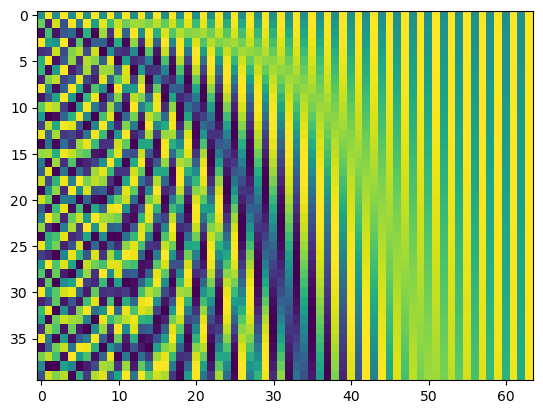

In [34]:
spe = SPE(64)
times = torch.linspace(0,1,40)
spe_emb = spe(times)
plt.imshow(spe_emb, aspect='auto')

In [10]:

## The vector must be of size Nxd  - for a N t value, there are d/2 cos(w_i * t) and d/2 sin (w_i * t) values


This is what it should look like : 
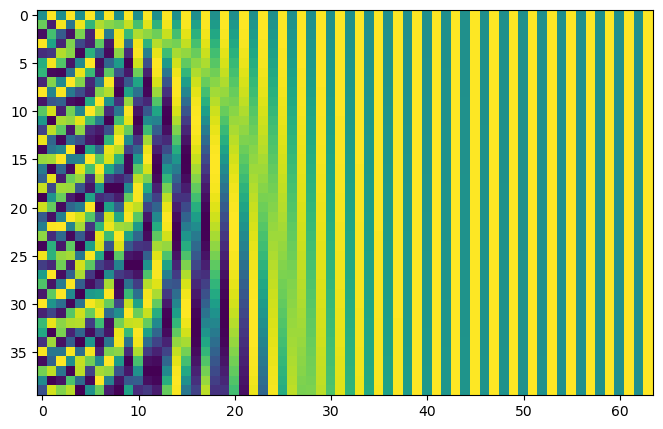

* Training loop

In [53]:
data = x1.T.float()

bsize = 16

dataset = torch.utils.data.TensorDataset(data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bsize, shuffle=True)

In [54]:
from tqdm import tqdm


deblender = MLP(spe_dim = 64,hidden_size=256)
optimizer = optim.Adam(deblender.parameters(), lr = 1e-3)
criterion = nn.MSELoss(reduction ='mean')



n_epochs = 100000
mean_loss = 0.
for i in tqdm(range(n_epochs)):
    for batch in dataloader:
        index = np.random.randint(0,1000,bsize)
        xcur = data[index]
    
        #Sampling x_0 in the 0 distribution 
        x0 = torch.randn_like(xcur)*0.7
        #Sampling alpha evenly distributed
        alpha = torch.rand(xcur.shape[0])
        #Creating x_alpha
        x_alpha = ((1-alpha[:,None])*x0 + alpha[:,None]*xcur)
    

        #Computing the loss for the output of the network
        output = deblender(x_alpha, alpha)
        expected = xcur-x0
        loss = criterion(expected, output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        mean_loss += loss.item()
        
        if i%2500==1:
            print(mean_loss/2500)
            mean_loss = 0
        

        

  0%|          | 0/100000 [00:00<?, ?it/s]


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

* Sampling process


In [125]:
def sample(deblender, n_samples, T):

    x_0 = torch.randn((n_samples,2))
    denoised_samples = [x_0]
    alpha = torch.arange(T)/T
    for t in range(1,T,1):
        x_a = denoised_samples[-1] + (alpha[t] - alpha[t-1])*deblender(denoised_samples[-1],alpha[t]*torch.ones(n_samples))
        denoised_samples.append(x_a)
    return denoised_samples

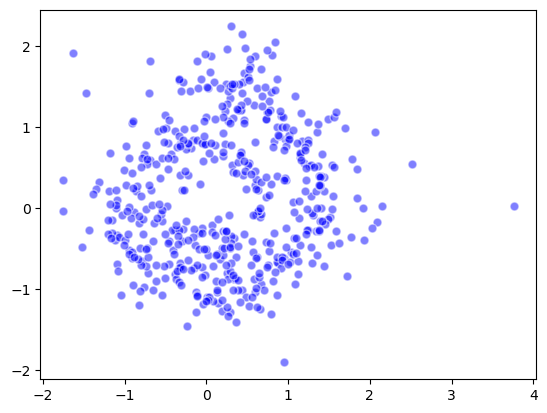

In [152]:
samples = sample(deblender, 500, 100)[-1]
#samples = samples[samples.mean(dim=1)<10]
plt.scatter(samples[:,0].detach(),samples[:,1].detach(), alpha=0.5, color='blue', edgecolor='white', s=40)